# Reconocimiento Facial con Deep Learning


El proyecto consiste en implementar un proyecto para el reconocimiento facial.

Para lograrlo, se consideran distintas arquitecturas de redes neuronales para procesamiento de imagenes, junto con el modelo preentrenado dlib , *shape_predictor_68_face_landmarks.dat*

Utiliza los modelos preentrenados disponible en Keras VGG16 e Inception. 

Los mejores resultados los Clasifica con el modelo VGG16 afinado. 

## Dataset

Es posible hacer reconocimiento facial de un dataset publico o generar un dataset propio.


En este caso vamos a generar un dataset personal y hacer reconocimiento facial al grupo familiar.


Para personalizar el problema es necesario crear una carpeta que contenga el dataset con las personas y rostros a identificar. 

Lo hacemos ejecutando la funcion *detectarProcesar_cara.py ID* , usando como parametro la identificacion de la persona.

Esta funcion lee las imagenes (del disco o captadas por la camara web) y aplica proprocesamiento. Recorta y alinea la cara, dejando la imagenes listas para entrenar los modelos.


Para el correcto funcionamiento es necesaria la libreria DLIB con el modelo preentrenado shape_predictor_68_face_landamarks.dat, disponible en https://github.com/davisking/dlib-models
Este modelo fue entrenado con las referencias faciales de muchas personas.



## Procesamiento de imagenes

Las imagenes son procesadas por openCV, en blanco y negro para trabajar en una sola dimension de colores.

openCV permite recolectar, recortar y alinear las imagenes, mientras que el modelo 68_landmarks.dat identifica los rasgos faciales. 

In [1]:
import numpy as np
import dlib
import cv2
import os
import time
import sys

In [2]:
DATASET = '/home/andres/Documentos/IA/Datasets/Caras/Familia/'

FORMATO = '.jpg' 

#DEFAULT_SIZE = (224,224,3) 
DEFAULT_SIZE = (224,224,1) 


In [3]:
data_path_cv2 = cv2.__path__[0]+'/data/'
haar_type = 'haarcascade_frontalface_default.xml'

video = cv2.VideoCapture(0)
face_cascada = cv2.CascadeClassifier(data_path_cv2+haar_type)


# DLIB
path_dlibModel = os.path.dirname(os.getcwd())
predictor_model = 'shape_predictor_68_face_landmarks.dat'

land_detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(path_dlibModel+'/'+predictor_model)



In [4]:
#modularizar!

cont = 0
seguir = True

while seguir:
    ret, frame = video.read()
    
    frameRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #sobreescribo formato de salida de GBR a RGB 
    gris = cv2.cvtColor(frameRGB, cv2.COLOR_RGB2GRAY)
    
    key = cv2.waitKey(1)
   
    caras_dlib = land_detector(gris,1)

    for cara in caras_dlib:
        x = cara.left()
        y = cara.top()
        w = cara.right() - x
        h = cara.bottom() - y
        
        landmarks = predictor(gris, cara)

        face_aligned = dlib.get_face_chip(frame, landmarks, DEFAULT_SIZE[0])
        
        face_aligned_grey = cv2.cvtColor(face_aligned, cv2.COLOR_RGB2GRAY)
        
        face_aligned_32 = np.asarray(face_aligned, dtype='float32') 
        im_expand = np.expand_dims(face_aligned_32, axis=0) 
        im_normalizada = (im_expand - np.min(im_expand)) / (np.max(im_expand) - np.min(im_expand))
            
        cv2.rectangle(frame, (x,y), (cara.right(),cara.bottom()), (0,255,0), 2)
        #cv2.rectangle(face_aligned, (x,y), (cara.right(),cara.bottom()), (0,255,0), 2)
        #cv2.rectangle(face_aligned_grey, (x,y), (cara.right(),cara.bottom()), (0,255,0), 2)

        
        for n in range(0,68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(frame, (x,y), 2, (255,0,0))
            #cv2.circle(face_aligned, (x,y), 2, (255,0,0))
            #cv2.circle(face_aligned_grey, (x,y), 2, (255,0,0))
        
            
        if key == ord('s'):
            path_nueva_foto = DATASET+ETIQUETA+'/'+ETIQUETA+time.strftime('_%d-%m-%Y_%H-%M-%S')
            nombre_foto = ETIQUETA+time.strftime('_%d-%m-%Y_%H-%M-%S')
            print("Sacaste nueva foto dlib ", nombre_foto)

            cv2.imwrite(path_nueva_foto+FORMATO, face_aligned_grey)
            
            cont += 1

        cv2.imshow('Cara alineada', frame)
        #cv2.imshow('Cara alineada', face_aligned)
        #cv2.imshow('Cara alineada', face_aligned_grey)

    
    if key == ord ('q'):
        seguir=False
        
video.release()
cv2.destroyAllWindows()


In [5]:
        
video.release()
cv2.destroyAllWindows()

# Deep Learning

### Las decisiones de implementacion fueron las siguientes:

#### . Consumo de imagenes del dataset : al principio consumia todo el dataset de una, pero saturaba la RAM. Para solucionarlo se decidio consumir las imagenes con un Generador de Imagenes, recolectando de a batches las imagenes de prueba sin arruinar la RAM;

#### . Definicion del modelo y fine tuning aplicado a rostros

#### . Hiperparametros, compilacion y entrenamiento del modelo

#### . Test del modelo

#### . Predicciones


In [6]:
import keras

In [7]:
from keras.layers import Input,Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Lambda
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras import regularizers
from keras.callbacks import EarlyStopping


import PIL
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib
import time
import os

### Generador de imagenes

Utilizo el generador de batches de imagenes provisto por Keras , para cargar imagenes de a batches de forma mas simple y robusta.

De lo contrario, cargando todo el dataset de una, satura la RAM


In [8]:
from keras.preprocessing.image import ImageDataGenerator

In [9]:
generador = ImageDataGenerator(validation_split=0.25,
                               rescale=1./255,
                               shear_range = 0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

#dir_dataset = '/Users/andresmanzalini/Documents/Datasets/Caras/Familia'
dir_dataset = '/home/andres/Documentos/IA/Datasets/Caras/Familia'


training_generator = generador.flow_from_directory(dir_dataset,
                                                   target_size = (224,224),
                                                   batch_size=8,
                                                   class_mode='categorical',
                                                   subset='training')

validation_generator = generador.flow_from_directory(dir_dataset,
                                                     target_size = (224,224),
                                                     batch_size=8,
                                                     class_mode='categorical',
                                                     subset='validation')

Found 459 images belonging to 5 classes.
Found 151 images belonging to 5 classes.


In [10]:
etiquetas = training_generator.class_indices
cant_ids = training_generator.num_classes
cant_ids

5

In [11]:
tags = list(etiquetas.keys()) 
tags

['Andres', 'Lu', 'Ma', 'Martin', 'Paula']

## Modelo VGG16

In [12]:
from keras.applications.vgg16 import preprocess_input


default_size=(224,224,3)
#default_size=(224,224,1)


# entrenar con imagenes blanco y negro -> 224, 224, 1

In [13]:
vgg = VGG16(input_shape=(default_size), weights='imagenet', include_top=False)

#congela las capas del modelo original salvo la ultima
for layer in vgg.layers:
    layer.trainable = False

vgg.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
# retocar estas ultimas capas segun la cantidad de personas a identificar y la salida de (7,7,512)
# afinar las ultimas capas densas fully connected segun cantidad de ids

c1 = Conv2D(256, (3,3), activation='relu')(vgg.output)
#c2 = Conv2D(64, (3,3), activation='relu')(c1)
p1 = MaxPooling2D(2,2)(c1)

f = Flatten()(p1) 

d1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(f) 

dr = Dropout(0.25)(d1)

d2 = Dense(256, activation='relu')(dr)

#jugar con los parametros de estas ultimas capas
out = Dense(cant_ids, activation='softmax')(d2) 



model = Model(outputs=out, inputs=vgg.input) 
    
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Compilacion y entrenamiento

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [16]:
import tensorflow

tensorflow.__version__


'2.4.1'

In [17]:
h = model.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        #epochs=15,
                        epochs=20,
                        steps_per_epoch=len(training_generator),
                        validation_steps=len(validation_generator),
                        callbacks=[es],
                        workers=4)


# hacer un modulo que entrene con gpu!
# VER COMO ENTRENAR EN PARALELO! gpu o worwers=4?

model.evaluate_generator(generator=validation_generator,
                         steps=len(validation_generator))



/home/andres/anaconda3/envs/envDeepLearning/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
58/58 [==============================] - 422s 7s/step - loss: 6.0972 - accuracy: 0.5373 - val_loss: 2.1706 - val_accuracy: 0.7947
Epoch 2/20
58/58 [==============================] - 441s 8s/step - loss: 1.7079 - accuracy: 0.8817 - val_loss: 1.1243 - val_accuracy: 0.9404
Epoch 3/20
58/58 [==============================] - 441s 8s/step - loss: 0.9395 - accuracy: 0.9631 - val_loss: 0.8433 - val_accuracy: 0.9073
Epoch 4/20
58/58 [==============================] - 441s 8s/step - loss: 0.6408 - accuracy: 0.9700 - val_loss: 0.6428 - val_accuracy: 0.9404
Epoch 5/20
58/58 [==============================] - 440s 8s/step - loss: 0.4352 - accuracy: 0.9785 - val_loss: 0.4381 - val_accuracy: 0.9404
Epoch 6/20
58/58 [==============================] - 440s 8s/step - loss: 0.2951 - accuracy: 0.9947 - val_loss: 0.3176 - val_accuracy: 0.9735
Epoch 7/20
58/58 [==============================] - 441s 8s/step - loss: 0.3197 - accuracy: 0.9496 - val_loss: 0.5415 - val_accuracy: 0.9007
Epoch 8/20
58

/home/andres/anaconda3/envs/envDeepLearning/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.22026246786117554, 0.9271523356437683]


PRUEBAS
 

Precision buena, de .97 

Perdida considerable, de .16

Hay undefitting 

&nbsp;

Aclaracion: Independientemente de la plataforma de entrenamiento (jupyter notebook o desde la ejecucion local del script) , los resultados de precision son buenos, de entre 0.95 y 0.98
&nbsp;

El problema se da en los resultados de perdida...
&nbsp;

El entrenamiento del modelo en el jupyter notebook presenta resultados de perdida altos, de entre 0.1 y 0.2
Por eso es mejor entrenar desde el script entrenarModelo.py , el cual presenta resultados de perdida validos, de entre 0.03 y 0.1 

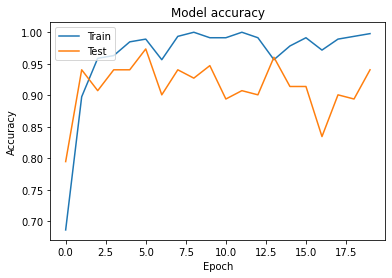

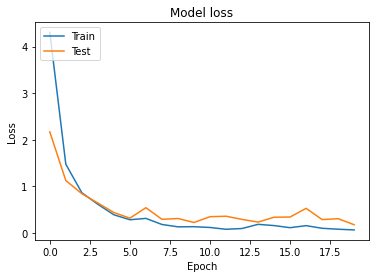

In [18]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Test del Modelo

Para testear el modelo es posible utilizar el modelo recientemente entrenado; o un modelo previamente guardado.


Si los resultados son buenos, puedo hacer las predicciones desde el modelo recien entrenado.

Si no, es posible cargar el modelo desde disco.


In [11]:
from keras.models import load_model



#model.save('reconocimientoFacial_tf2.h5')

#def cargar_modelo():
#modelo_cargado = load_model('faceRecognition_model.h5')#NOMBRE_MODELO
#    return model



In [19]:
#elijo usar modelo recien entrenado (en RAM) o usar el modelo guardado en disco ??


#modelo = load_model('reconocimientoFacial.h5')

modelo = model

In [20]:
!pip install visualkeras

In [21]:
import visualkeras

#visualkeras.layered_view(modelo)
visualkeras.layered_view(modelo, to_file='vgg16.png').show() # write and show
#visualkeras.layered_view(modelo, legend=True) #, font=font)  # font is optional!
#visualkeras.layered_view(model, type_ignore=[ZeroPadding2D, Dropout, Flatten])

## Predicciones estaticas


Del disco al programa, en formato .jpg

In [14]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py

#convert the images from RGB to BGR, then will zero-center each color channel with
#respect to the ImageNet dataset, without scaling.


In [15]:
im = '/Users/andresmanzalini/Documents/Andres_Prueba.jpg'

img = image.load_img(im, target_size=(224, 224))   #MAL!! el modelo o la prediccion?
print(img)
x = image.img_to_array(img)
print(x.dtype)
x = np.expand_dims(x, axis=0)
#print('x expandida ',x)
x = preprocess_input(x)     #RARO. esto parece que esta mal! que hace con la imagen?
#print('x preprocess ', x)  #wat?
prediccion = model.predict(x)
print(prediccion)
pred = np.argmax(prediccion) 
pred
tags[pred]


<PIL.Image.Image image mode=RGB size=224x224 at 0x1494531D0>
float32
[[1.0000000e+00 1.6545037e-32 1.1565375e-32 2.5648252e-31 2.1980701e-28]]


'Andres'

In [16]:
preds = prediccion[0][:]
print('predicciones ',preds)
print('etiqueta ',tags[pred])
print("prediccion: {0:.3f}". format(preds[pred]))


predicciones  [1.0000000e+00 1.6545037e-32 1.1565375e-32 2.5648252e-31 2.1980701e-28]
etiqueta  Andres
prediccion: 1.000


## Predicciones por webcam

Usa opencv y dlib.

Tener en cuenta que las imagenes del dataset tienen el formato RGB, predefinido por dlib al alinear las caras con chip_align(face), de la libreria PIL.

Por eso hay que ser consistentes con el formato de salida de la camara web, para entrenar y predecir con los mismos formatos y tipos de datos.



In [23]:
# ejecutar a partir de aca!


In [22]:
#OpenCV
data_path_cv2 = cv2.__path__[0]+'/data/'
haar_type = 'haarcascade_frontalface_default.xml'

video = cv2.VideoCapture(0)
face_cascada = cv2.CascadeClassifier(data_path_cv2+haar_type)


#DLIB
path_DLIBmodel = os.path.dirname(os.getcwd())+'/shape_predictor_68_face_landmarks.dat'
land_detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(path_DLIBmodel)



In [23]:
seguir = True
while seguir:
    ret, frame = video.read()
    #gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frameRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #sobreescribo formato de salida de GBR a RGB 
    gris = cv2.cvtColor(frameRGB, cv2.COLOR_RGB2GRAY)
    
    key = cv2.waitKey(1) 

    caras_dlib = land_detector(gris,1)

    for cara in caras_dlib:
        x = cara.left()
        y = cara.top()
        w = cara.right() - x
        h = cara.bottom() - y
        
        landmarks = predictor(gris, cara)
        face_aligned = dlib.get_face_chip(frame, landmarks, 224)
        
        face_aligned_32 = np.asarray(face_aligned, dtype='float32') 
        #print('face aligned 32 ', face_aligned_32)
        im_expand = np.expand_dims(face_aligned_32, axis=0) 
        #print('expand ', im_expand.shape)
        im_normalizada = (im_expand - np.min(im_expand)) / (np.max(im_expand) - np.min(im_expand))
        #normalizando predice probabilidades!
        
        prediccion = modelo.predict(im_normalizada)
        
        pred = np.argmax(prediccion)
        proba = prediccion[:,pred]
        tag = tags[pred]+": "

        
        if proba > .7: # & reconoce al mismo id durante 2s
            print('{}: {}'.format(tag, proba))
            cv2.putText(frame, tag+str(proba), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        cv2.rectangle(frame, (x,y), (cara.right(),cara.bottom()), (0,255,0), 3)
        
        for n in range(0,68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(frame, (x,y), 3, (255,0,0))

        cv2.imshow('Cara alineada', face_aligned)


    cv2.imshow('Frame',frame)
    
    if key == ord ('q'):
        seguir=False
        

video.release()
cv2.destroyAllWindows()

Ma: : [0.9761529]
Ma: : [0.966515]
Ma: : [0.9630064]
Ma: : [0.9673304]
Ma: : [0.93011206]
Andres: : [0.9997365]
Andres: : [0.99989474]
Andres: : [0.9995871]
Andres: : [0.999908]
Andres: : [0.99979025]
Andres: : [0.99991715]
Andres: : [0.9998454]
Andres: : [0.9999331]
Andres: : [0.9996718]
Andres: : [0.9997564]
Andres: : [0.99979895]
Andres: : [0.99594057]
Andres: : [0.97243506]
Andres: : [0.99741155]
Andres: : [0.99664813]
Andres: : [0.99862635]
Andres: : [0.98796785]
Andres: : [0.9024555]
Andres: : [0.9896152]
Andres: : [0.98540086]
Andres: : [0.98913515]


In [29]:
video.release()
cv2.destroyAllWindows()

In [ ]:
# Guardar modelo???

#def guardar_modelo(modelo):
#    modelo.save('./faceRecognition_model.h5')  # creates a HDF5 file 'my_model.h5'
#    del modelo


# Conclusion


El procesamiento de imagenes esta hecho con openCV. Esta libreria provee la funcionalidad para obtener imagenes y procesarlas. Permite jugar con los filtros y transformaciones geometricas.


El reconocimiento facial esta hecho con haarcascade y con el modelo preentrenado de la libreria dlib,  *shape_predictor_68_face_landmarks.dat*


Respecto al Deep Learning, el modelo VGG16 es bueno para el reconocimiento facial, ya que fue entrenado para extraer carecteristicas mas generales de las imagenes. 

La clave para la precision esta en la combinacion entre la deteccion de expresiones faciales (modelo preentrenado facial_landmarks_68), y el modelo preentrenado de Keras, VGG16 


Los resultados son bastante precisos a pesar de la poca informacion de prueba.


# En desarrollo...

## Redes siamesas 


One-shot learning

Comparo imagenes del mismo subconjunto y calculo el triplet loss

In [39]:
#from tensorflow.keras import Lambda
import tensorflow.keras.backend as K
from keras.layers import Input


In [69]:
#uso de triplet loss.
#compara de a 3 medidas a la vez, y se va aproximando al positivo a medida que entrena el algoritmo

vgg = VGG16(input_shape=(default_size), weights='imagenet', include_top=False)#, classes=3)

#vgg.summary()
for layer in vgg.layers:
    layer.trainable = False


vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [70]:
f = Flatten()(vgg.output) #aplano vgg con sus respectivos pesos definidos en imagenet

x = BatchNormalization()(f)

d = Dropout(0.2)(x)

#kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01))
out = Dense(4, activation='softmax')(d)


In [71]:
model = Model(input=vgg.input, outputs=out) #input model o vgg?

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/Users/andresmanzalini/miniconda3/envs/envDeepLearning/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [106]:
#seq_model = tf.keras.Sequential(vgg)

left_input = Input(shape=default_size)
right_input = Input(shape=default_size)

#model = Sequential()
#left_output = model(left_input)
right_output = vgg(right_input)
left_output

<tf.Tensor 'vgg16_4/block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [90]:
distance_euclid = Lambda(lambda tensors : K.abs( tensors[0] - tensors[1] ))([left_output , right_output])

In [93]:
outs = Dense(1 , activation='sigmoid')(distance_euclid)

#model = Model(input=vgg.input, outputs=out) #input model o vgg?

model = Model([left_input,right_input], outputs)
model = Model(inputs=[left_input, right_input], outputs=outs)


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [94]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 7, 7, 512)    14714688    input_32[0][0]                   
                                                                 input_33[0][0]                   
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 7, 7, 512)    0           vgg16[1][0]                      
          

In [74]:
# articulos sobre redes neuronales siamesas

# https://medium.com/predict/face-recognition-from-scratch-using-siamese-networks-and-tensorflow-df03e32f8cd0

# https://www.codeproject.com/Articles/1253224/Keras-Implementation-of-Siamese-like-Networks

# https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d

## FaceNet

In [ ]:
# https://arxiv.org/pdf/1503.03832.pdf

# https://spanish.agatetepe.com.br/hacer-su-propio-sistema-de-reconocimiento-de-rostros/

In [ ]:
#el uso de vgg16 requiere la mencion del sgte paper 
# https://arxiv.org/abs/1409.1556

# Trabajo futuro 

Respecto a los datos de entrenamiento y prueba, lo ideal seria hacer un script que cargue automaticamente los datasets cada vez que identifica (durante un minimo intervalo de tiempo) a una persona ya registrada en el dataset.

Tambien es importante implementar FaceNet con el mismo dataset, para el mismo problema y comprobar los resultado.
Esto permite definir que tan bien predice una red neuronal convolucional simple (VGG16) comparado con LA red neuronal convolucional FaceNet 